## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import joblib
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import variance
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

## Data Loading 

In [2]:
data = pd.read_csv('train.csv')

data.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test_data = pd.read_csv('test.csv')

test_data.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis 

#### Shape of Train & Test data 

In [16]:
print('Train Data = ', data.shape)
print('Test Data = ', test_data.shape)

Train Data =  (4209, 378)
Test Data =  (4209, 377)


1. Train data contain 8 categorical, 368 binary features and class label.
2. Test data contain 8 categorical & 368 binary features.
3. Both datasets have 4209 datapoints.

#### Checking for any missing values 

In [17]:
nan_in_data = data.isnull().sum().any()
nan_in_data

False

In [18]:
nan_in_test_data = test_data.isnull().sum().any()
nan_in_test_data

False

There are not missing values in Train & Test dataset

####  Checking for duplicate rows

In [19]:
duplicate_in_data = data.duplicated().sum().any()
print(duplicate_in_data)

duplicate_in_test_data = test_data.duplicated().sum().any()
print(duplicate_in_test_data)

False
False


There are not duplicate rows in Train & Test dataset

#### Checking for duplicate ID's 

In [20]:
duplicate_id_in_data = data['ID'].duplicated().sum().any()
print(duplicate_id_in_data)

duplicate_id_in_test_data = test_data['ID'].duplicated().sum().any()
print(duplicate_id_in_test_data)

False
False


 There are not duplicate ID's in Train & Test dataset

#### Checking distribution of dependent variable 

In [4]:
labels = data['y']

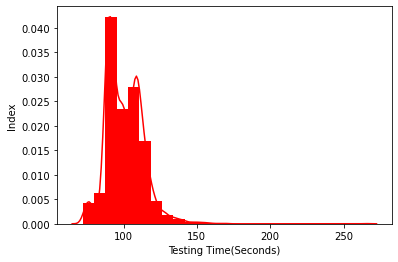

In [22]:
ax = sns.distplot(labels,
                  bins=25,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Testing Time(Seconds)', ylabel='Index')
 
plt.show()

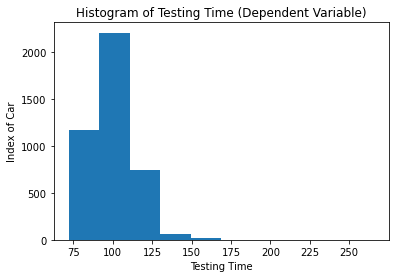

In [23]:
plt.hist(labels)
plt.xlabel('Testing Time')
plt.ylabel('Index of Car')
plt.title('Histogram of Testing Time (Dependent Variable)')
plt.show()

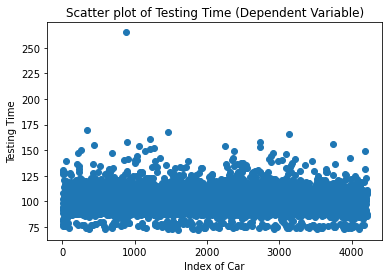

In [24]:
plt.scatter(np.arange(1,4210,1), labels)
plt.xlabel('Index of Car')
plt.ylabel('Testing Time')
plt.title('Scatter plot of Testing Time (Dependent Variable)')
plt.show()

1. From above plots we can say that data is right tailed skewed.
2. After seeing scatter plot we observe that most of the cars testing time lies between 75 sec. to 150 sec.
3. Now we can say that datapoints having testing time above 150 sec. are outliers.
4. For better understanding of outliers we compute percentiles of dependent variables.

#### 90th Percentile to 100th  

In [25]:
for i in range(90 , 101, 1):
    print(i ,'th percentile:', data.y.quantile(i/100)) 

90 th percentile: 115.25
91 th percentile: 116.04840000000002
92 th percentile: 116.89160000000001
93 th percentile: 118.0376
94 th percentile: 119.056
95 th percentile: 120.806
96 th percentile: 122.4
97 th percentile: 125.89319999999998
98 th percentile: 129.2992
99 th percentile: 137.43040000000002
100 th percentile: 265.32


#### 99th Percentile to 99.9th 

In [26]:
p = 99
i = 0
while(i < 1):
    p = p + i
    i = i + 0.1
    print(p ,'th percentile:', data.y.quantile(p/100))
    p = 99

99 th percentile: 137.43040000000002
99.1 th percentile: 139.09024
99.2 th percentile: 140.18360000000004
99.3 th percentile: 140.81639999999993
99.4 th percentile: 142.6480000000001
99.5 th percentile: 146.2304000000001
99.6 th percentile: 149.0374399999998
99.7 th percentile: 151.4276800000003
99.8 th percentile: 154.68695999999994
99.9 th percentile: 160.38328000000087
100.0 th percentile: 265.32


99.8 Percent of datapoints take less time than 155 sec. So we will consider datapoints having testing time above 155 sec. 
as outliers.

#### Removing outliers 

In [4]:
train_data = data.drop(data[data['y'] > 155].index).reset_index(drop = True)

#test_data = test_data.drop(test_data[test_data['y'] > 155].index).reset_index(drop = True)

In [28]:
print(train_data.shape)
#print(test_data.shape)

(4201, 378)


#### Analysis of Categorical features 

<AxesSubplot:xlabel='X8', ylabel='y'>

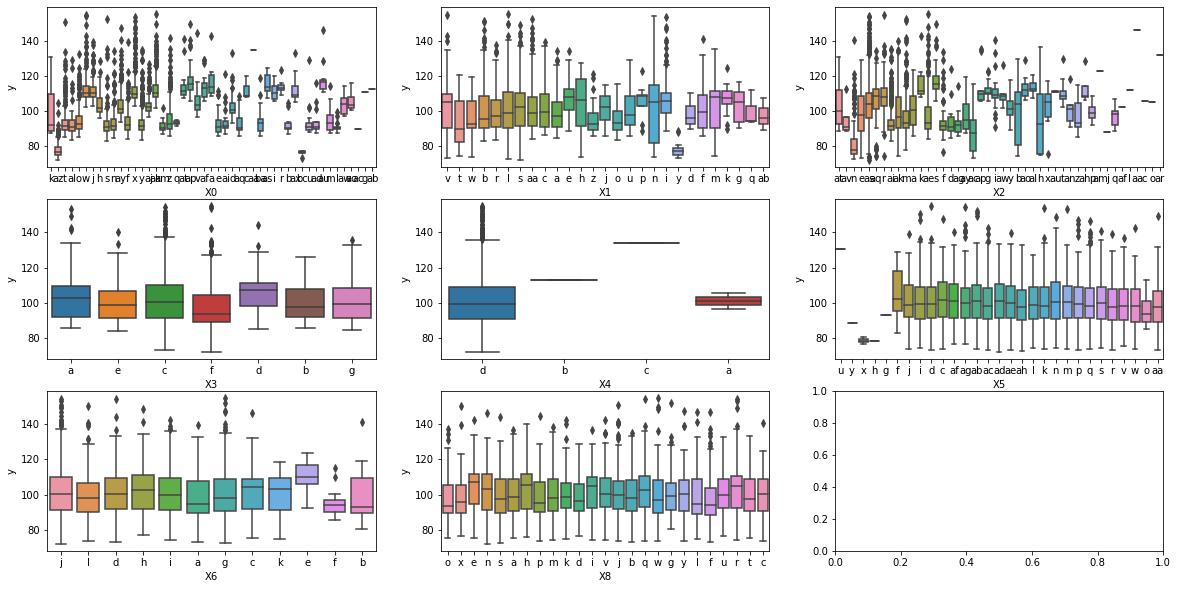

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10))
sns.boxplot( x = 'X0',y = 'y', data = train_data, ax = ax[0, 0])
sns.boxplot( x = 'X1',y = 'y', data = train_data, ax = ax[0, 1])
sns.boxplot( x = 'X2',y = 'y', data = train_data, ax = ax[0, 2])
sns.boxplot( x = 'X3',y = 'y', data = train_data, ax = ax[1, 0])
sns.boxplot( x = 'X4',y = 'y', data = train_data, ax = ax[1, 1])
sns.boxplot( x = 'X5',y = 'y', data = train_data, ax = ax[1, 2])
sns.boxplot( x = 'X6',y = 'y', data = train_data, ax = ax[2, 0])
sns.boxplot( x = 'X8',y = 'y', data = train_data, ax = ax[2, 1])

1. We removed outliers from training data
2. From above boxplots we can say that all categorical features have good variance except X4
3. Almost categories median is around 100 (Just an observation)
4. From above boxplots we can see that each category have reasonable datapoints.
5. X4 feature gives less information so will remove it.

In [5]:
train_data = train_data.drop(columns = ['X4'])

test_data = test_data.drop(columns = ['X4'])

In [31]:
print(train_data.shape)
print(test_data.shape)

(4201, 377)
(4209, 376)


#### Analysis of Binary features 

In [6]:
binary_features = train_data.drop(columns = ['ID', 'y', 'X0', 'X1', 'X2', 'X3', 'X5', 'X6', 'X8'])
clm_lst = list(binary_features.columns)

var_lst = []
for ele in clm_lst:
    var_lst.append(variance(binary_features[ele]))
    
var_df = pd.DataFrame()
var_df['feature'] = clm_lst
var_df['variance'] = var_lst

var_df.head()

,feature,variance
0,X10,0.013156
1,X11,0.000000
2,X12,0.068971
3,X13,0.054510
4,X14,0.244908


In [8]:
var_df

,feature,variance
0,X10,0.013156
1,X11,0.000000
2,X12,0.068971
3,X13,0.054510
4,X14,0.244908
...,...,...
363,X380,0.008030
364,X382,0.007561
365,X383,0.001664
366,X384,0.000476


Plotting scatter plot of above dataframe

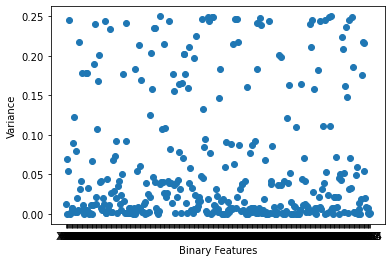

In [33]:
plt.scatter(var_df['feature'], var_df['variance'])
plt.xlabel('Binary Features')
plt.ylabel('Variance')
plt.show()

From above scatter plot we will see that many features have zero variance and some points are overlapping means having same variance. And that is not good for predictions. So will remove those features. 

#### Removing Features having Zero variance 

In [9]:
ftr_zero_var = []
for i in range(var_df.shape[0]):
    if var_df['variance'][i] == 0:
        ftr_zero_var.append(var_df['feature'][i])

In [9]:
joblib.dump(ftr_zero_var, 'FeatureZeroVar.pkl')

['FeatureZeroVar.pkl']

In [11]:
train_data = train_data.drop(columns = ftr_zero_var)

test_data = test_data.drop(columns = ftr_zero_var)

In [12]:
print(train_data.shape)
print(test_data.shape)

(4201, 364)
(4209, 363)


#### Removing Features having Same variance 

In [11]:
index_zero_var = var_df.index[var_df['variance'] == 0].tolist()
var_df_upd = var_df.drop(index_zero_var, axis = 0).reset_index(drop = True)

ftr_same_var = []
for i in range(var_df_upd.shape[0]):
    for j in range(var_df_upd.shape[0]):
        if var_df_upd['feature'][i] == var_df_upd['feature'][j]:
            continue
        elif var_df_upd['variance'][i] == var_df_upd['variance'][j]:
            if var_df_upd['feature'][i] not in ftr_same_var:
                ftr_same_var.append(var_df_upd['feature'][i])
            elif var_df_upd['feature'][j] not in ftr_same_var:
                ftr_same_var.append(var_df_upd['feature'][j])
        else:
            continue 

In [14]:
joblib.dump(ftr_same_var, 'FeatureSameVar.pkl')

['FeatureSameVar.pkl']

In [42]:
train_data = train_data.drop(columns = ftr_same_var)

test_data = test_data.drop(columns = ftr_same_var)

In [43]:
print(train_data.shape)
print(test_data.shape)

(4201, 167)
(4209, 166)


After removing features with zero and same variance dimension of dataset reduced and that is good for modelling.

#### Finding out top 10 Binary features

In [44]:
binary_features = train_data.drop(columns = ['ID', 'y', 'X0', 'X1', 'X2', 'X3', 'X5', 'X6', 'X8'])
labels = train_data['y']

rfr = RandomForestRegressor()
rfr.fit(binary_features, labels)

RandomForestRegressor()

In [45]:
ftr_imp_bin = list(rfr.feature_importances_)
ftr_name_bin = list(binary_features.columns)
ftr_imp_dict = {ftr_name_bin[i]: ftr_imp_bin[i] for i in range(len(ftr_name_bin))}
ftr_imp_dict_sorted = dict(sorted(ftr_imp_dict.items(), key=lambda item: item[1]))

ftr_imp_df = pd.DataFrame(list(ftr_imp_dict_sorted.items()), columns = ['Features', 'Importance'])

ftr_imp_df.tail(10)

,Features,Importance
148,X127,0.006979
149,X51,0.007568
150,X137,0.007878
151,X64,0.008253
152,X46,0.009892
153,X117,0.012723
154,X115,0.054603
155,X189,0.081120
156,X315,0.088211
157,X314,0.452790


Above, using RandomForest we found out top 10 binary features. We will plot boxplot of them for analysis.

<AxesSubplot:xlabel='X51', ylabel='y'>

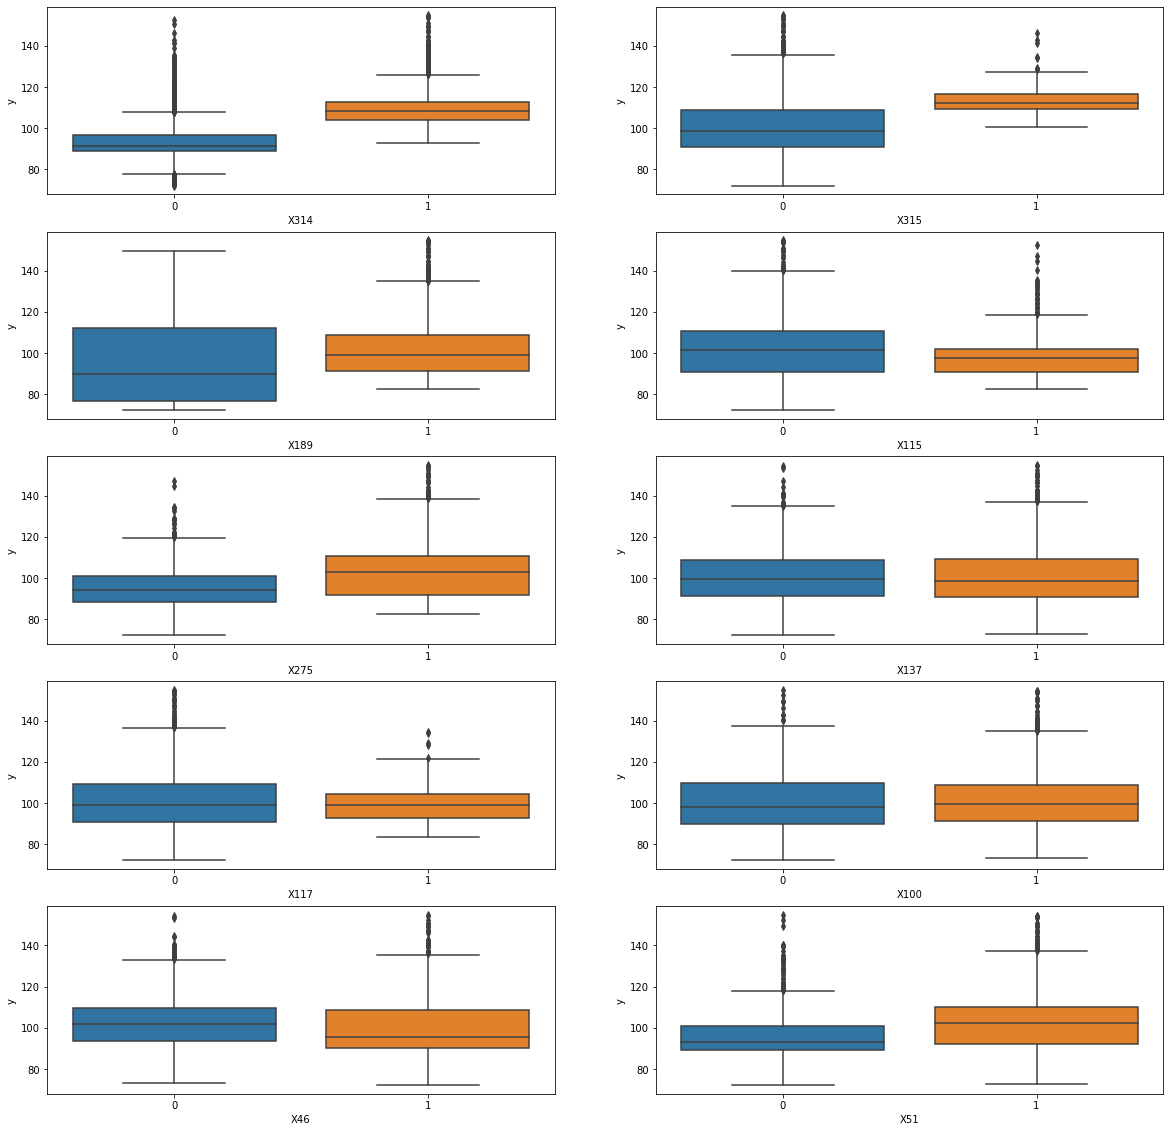

In [46]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))
sns.boxplot( x = 'X314',y = 'y', data = train_data, ax = ax[0, 0])
sns.boxplot( x = 'X315',y = 'y', data = train_data, ax = ax[0, 1])
sns.boxplot( x = 'X189',y = 'y', data = train_data, ax = ax[1, 0])
sns.boxplot( x = 'X115',y = 'y', data = train_data, ax = ax[1, 1])
sns.boxplot( x = 'X275',y = 'y', data = train_data, ax = ax[2, 0])
sns.boxplot( x = 'X137',y = 'y', data = train_data, ax = ax[2, 1])
sns.boxplot( x = 'X117',y = 'y', data = train_data, ax = ax[3, 0])
sns.boxplot( x = 'X100',y = 'y', data = train_data, ax = ax[3, 1])
sns.boxplot( x = 'X46',y = 'y', data = train_data, ax = ax[4, 0])
sns.boxplot( x = 'X51',y = 'y', data = train_data, ax = ax[4, 1])

From above plots we can see that these features are well distributed and add values while prediction time comes.

In [47]:
train_data.to_csv('final_train.csv')
test_data.to_csv('final_test.csv')